In [1]:
from data import get_solanki_data, plot_data, get_silso_data, centre_x, sample_interval, sample_meaninterval, split_train_test, to_tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import GPy

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
from transforms import (
    identity, 
    log_transform, exp_transform, 
    invsoftplus_transform, softplus_transform, 
    power_transform, 
)

from utility import (
    plot_transform, 
)

In [3]:
data = get_silso_data('SN_m_tot_V2.0')
data = centre_x(data)

sampling_interval = 4  # months
f_s = 12 / sampling_interval
sampledata_int = sample_interval(data, sampling_interval)
sampledata_mean = sample_meaninterval(data, sampling_interval, ['year_frac', 'ssn_total'])
# sampledata_mean['year_frac'] += sampling_interval / 12 / 2
sampledata = sampledata_mean

min_train_year = 1848  # 1900
min_test_year = 2010  # 1979  # 2018
traindata, testdata = split_train_test(sampledata, min_test_year=min_test_year, min_train_year=min_train_year, year_col='year_frac')

train_x, train_y = traindata['year_frac'].to_numpy().reshape((-1,1)), traindata['ssn_total'].to_numpy().reshape((-1,1))
test_x, test_y = testdata['year_frac'].to_numpy().reshape((-1,1)), testdata['ssn_total'].to_numpy().reshape((-1,1))

history_x = np.concatenate([train_x, test_x])
future_x = np.array([2022 + sampling_interval * 1/12*(i+1) for i in range(11*12//sampling_interval)]).reshape((-1,1))
all_x = np.concatenate([history_x, future_x])

../data/SILSO data/SN_m_tot_V2.0.csv


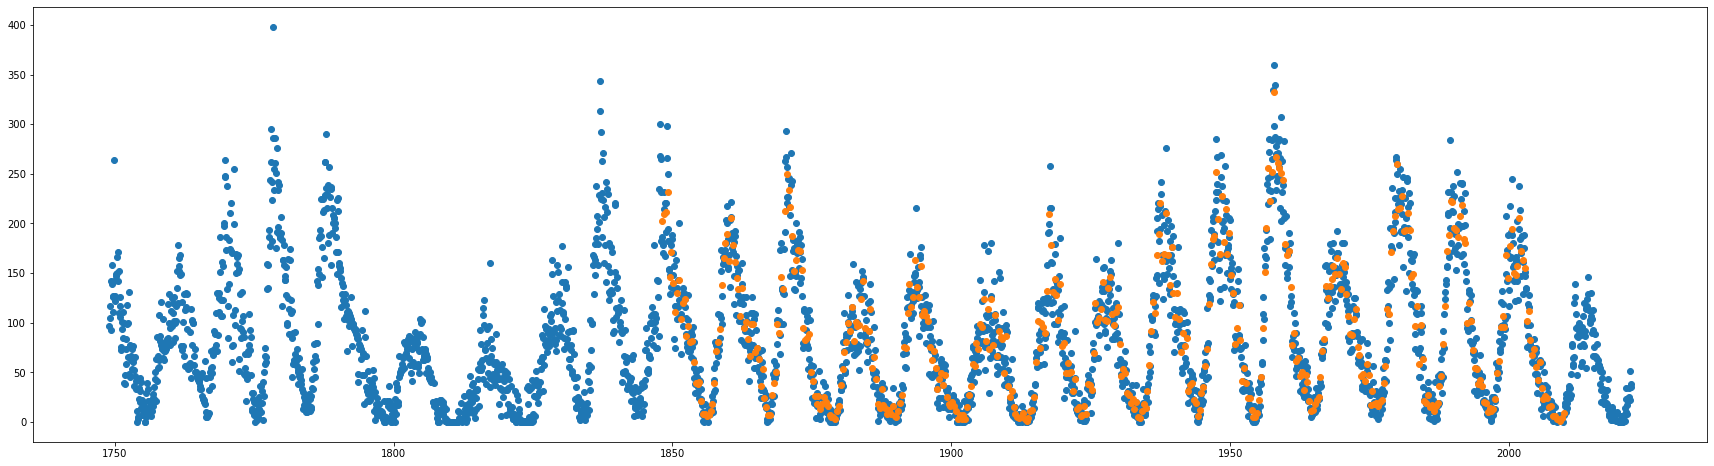

In [5]:
fig, ax = plot_data(data, 'year_frac', 'ssn_total')
ax.scatter(train_x, train_y)

In [6]:
k_noise = GPy.kern.White(1)

k_rq = GPy.kern.RatQuad(1) 
k_period_1 = GPy.kern.StdPeriodic(1,period=10,lengthscale=1,variance=1)
k_period_2 = GPy.kern.StdPeriodic(1,period=5,lengthscale=1,variance=1)
k_mul = k_rq*k_period_1
k_mul_2 = k_rq*k_period_2
    
k_add = k_mul + k_mul_2 + k_noise 

In [7]:
m = GPy.models.GPRegression(train_x, train_y, k_add)

In [8]:
# m.optimize_restarts(messages=True, num_restarts=10)
m.optimize(messages=True)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fb4a61f3d30>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fb4a61f37f0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fb4a612a790>]}

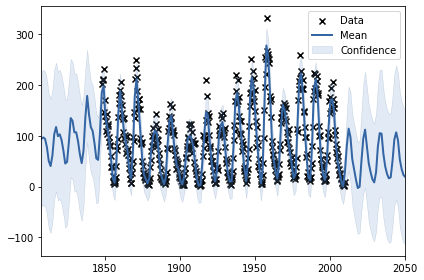

In [9]:
m.plot()

In [10]:
def plot_model_fit(model, f_s=12, figsize=(14, 6), transform=identity):
    pred, var = model.predict(all_x)
    pred = pred.flatten()
    var = var.flatten()
    lower = pred - np.sqrt(var)
    upper = pred + np.sqrt(var)

    if transform == identity: 
        ts = [(transform, 'ssn_total'), ]
        nplots = 1
    else:
        ts = [(transform, 'transformed ssn_total'), (identity, 'ssn_total')]
        nplots = 2
    fig, ax = plt.subplots(nplots, 1, figsize=figsize)
    for i,(t,ylbl) in enumerate(ts):
        ax_t = ax if nplots == 1 else ax[i]
        ax_t.set_title('Model fit')
        ax_t.set_xlabel('t')
        ax_t.set_ylabel(ylbl)
        ax_t.plot(all_x, pred, label='Predicted mean')
        ax_t.fill_between(all_x.flatten(), lower, upper, alpha=0.5, label='2 Stdev.')
        data_ = data.loc[data.year_frac > min_train_year]
        ax_t.scatter(data_.year_frac, data_.ssn_total, label='Raw obs.', marker='x', alpha=0.3)
        ax_t.scatter(train_x, train_y, label='Train')
        ax_t.scatter(test_x, test_y, label='Test')
        ax_t.legend(loc='upper left', ncol=2)

    fig.tight_layout()
    return fig, ax

(<Figure size 1008x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Model fit'}, xlabel='t', ylabel='ssn_total'>)

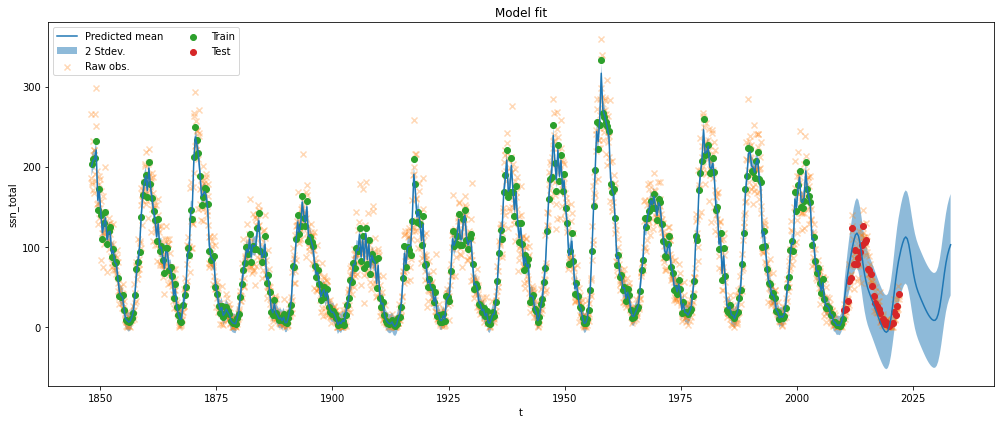

In [11]:
plot_model_fit(m)

## SWPC prediction data

In [12]:
pred_data = pd.read_json('../data/SWPC data/predicted-solar-cycle.json')

In [13]:
def get_pred_year():
    return [int(i.split('-')[0]) for i in pred_data['time-tag']]

def get_pred_month():
    return [int(i.split('-')[1]) for i in pred_data['time-tag']]

In [14]:
pred_data['year_frac'] = [y + (m-1)/12 for y, m in zip(get_pred_year(), get_pred_month())]

In [15]:
pred_data

,time-tag,predicted_ssn,high_ssn,low_ssn,predicted_f10.7,high_f10.7,low_f10.7,year_frac
0,2021-06,26.1,27.1,25.1,80.30,81.3,79.3,2021.416667
1,2021-07,27.0,29.0,25.0,80.10,81.1,79.1,2021.500000
2,2021-08,28.8,31.8,25.8,80.60,82.6,78.6,2021.583333
3,2021-09,30.5,35.5,25.5,81.20,84.2,78.2,2021.666667
4,2021-10,31.7,36.7,26.7,81.90,85.9,77.9,2021.750000
...,...,...,...,...,...,...,...,...
230,2040-08,0.0,9.0,0.0,67.73,8.0,67.7,2040.583333
231,2040-09,0.0,9.0,0.0,67.73,8.0,67.7,2040.666667
232,2040-10,0.0,9.0,0.0,67.73,8.0,67.7,2040.750000
233,2040-11,0.0,9.0,0.0,67.73,8.0,67.7,2040.833333


In [16]:
x_pred, y_pred = pred_data['year_frac'].to_numpy().reshape((-1,1)), pred_data['predicted_ssn'].to_numpy().reshape((-1,1))

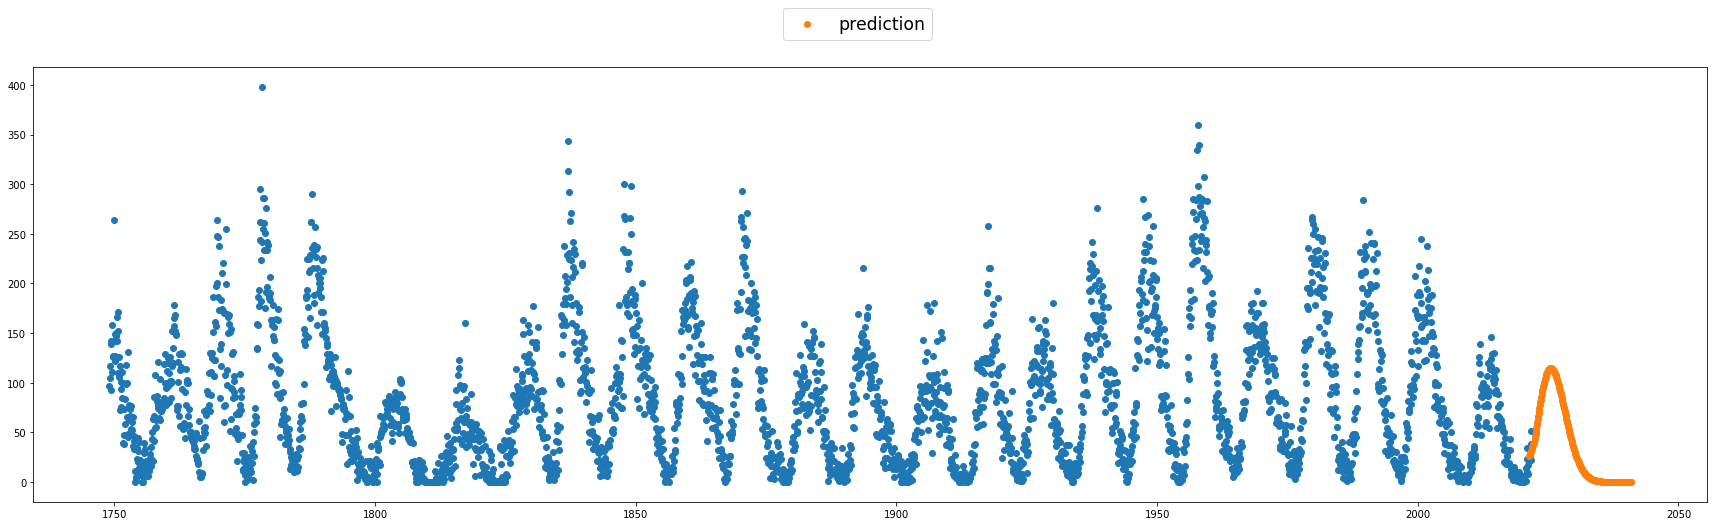

In [17]:
fig, ax = plot_data(data, 'year_frac', 'ssn_total')
ax.scatter(x_pred, y_pred, label='prediction')
fig.legend(loc='upper center', fontsize='xx-large')

In [18]:
k_noise = GPy.kern.White(1)

k_rq = GPy.kern.RatQuad(1) 
k_period_1 = GPy.kern.StdPeriodic(1,period=10,lengthscale=1,variance=1)
k_mul = k_rq*k_period_1
    
k_add = k_mul + k_noise 

In [19]:
m = GPy.models.GPRegression(x_pred, y_pred, k_add)
m.optimize(messages=True)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fb4a5f29f40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fb4a5eb7580>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fb4a5eb7730>]}

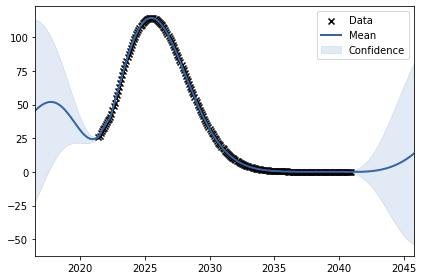

In [20]:
m.plot()

## Multi-fidelity

In [21]:
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [22]:
x_train_l = x_pred
x_train_h = data['year_frac'].to_numpy().reshape((-1,1))
y_train_l = y_pred
y_train_h = data['ssn_total'].to_numpy().reshape((-1,1))

In [23]:
X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], 
                                                    [y_train_l, y_train_h])

In [24]:
def kern_1():
    k_noise = GPy.kern.White(1)

    k_rq = GPy.kern.RatQuad(1) 
    k_period_1 = GPy.kern.StdPeriodic(1,period=10,lengthscale=1,variance=1)
    k_period_2 = GPy.kern.StdPeriodic(1,period=5,lengthscale=1,variance=1)
    k_mul = k_rq*k_period_1
    k_mul_2 = k_rq*k_period_2

    k_add = k_mul + k_mul_2 + k_noise
    return k_add

def kern_2():
    k_noise = GPy.kern.White(1)

    k_rq = GPy.kern.RatQuad(1) 
    k_period_1 = GPy.kern.StdPeriodic(1,period=10,lengthscale=1,variance=1)
    k_mul = k_rq*k_period_1

    k_add = k_mul + k_noise 
    return k_add

In [25]:
kernels = [kern_1(), kern_2()]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)

array([0])

In [26]:
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
lin_mf_model.optimize()

 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 16058.492200586135
Optimization restart 2/5, f = 15969.179256132247


 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/stationary.py:706: RuntimeWarning:overflow encountered in square
 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/stationary.py:711: RuntimeWarning:overflow encountered in square
 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/stationary.py:718: RuntimeWarning:overflow encountered in square
 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/stationary.py:720: RuntimeWarning:invalid value encountered in multiply
 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:151: RuntimeWarning:overflow encountered in square
 /home/mr892/sunspots/venv_sunspots/lib/python3.8/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:divide by

Optimization restart 3/5, f = 15994.877307790923
Optimization restart 4/5, f = 15944.022216156905
Optimization restart 5/5, f = 15058.162596609262


In [27]:
x_plot = all_x
X_plot = convert_x_list_to_array([x_plot, x_plot])
X_plot_l = X_plot[:len(x_plot)]
X_plot_h = X_plot[len(x_plot):]

lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

In [28]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

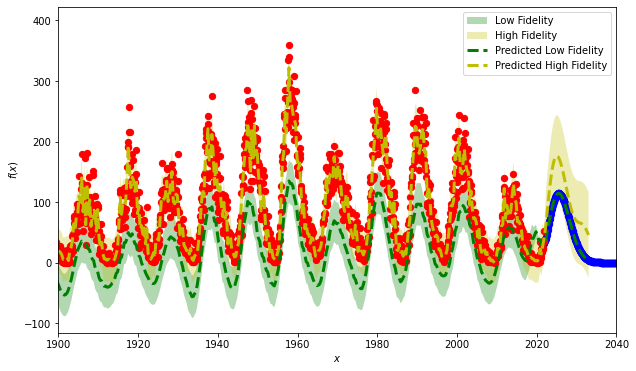

In [29]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
ax.fill_between(x_plot.flatten(), (lf_mean_lin_mf_model - 1.96*lf_std_lin_mf_model).flatten(), 
                 (lf_mean_lin_mf_model + 1.96*lf_std_lin_mf_model).flatten(), facecolor='g', alpha=0.3)
ax.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='y', alpha=0.3)

ax.plot(x_plot, lf_mean_lin_mf_model, '--', color='g', linewidth=3)
ax.plot(x_plot, hf_mean_lin_mf_model, '--', color='y', linewidth=3)
ax.scatter(x_train_l, y_train_l, color='b', s=40)
ax.scatter(x_train_h, y_train_h, color='r', s=40)
ax.set_ylabel('$f(x)$')
ax.set_xlabel('$x$')
ax.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity'])

ax.set_xlim((1900, 2040))

mlai.write_figure('linear-multi-fidelity-model.svg', directory='./uq')

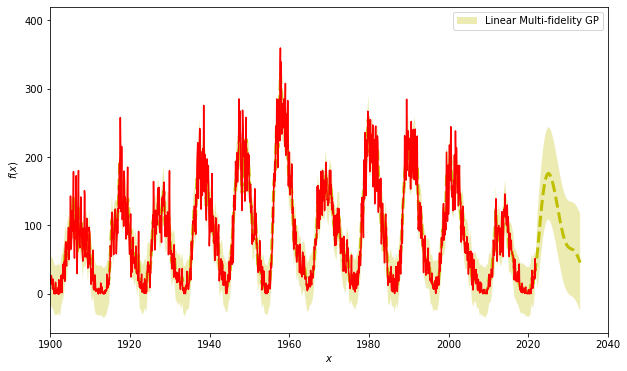

In [30]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

ax.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='y', alpha=0.3)

ax.plot(x_plot, hf_mean_lin_mf_model, '--', color='y', linewidth=3)
ax.plot(data['year_frac'], data['ssn_total'], color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.legend(['Linear Multi-fidelity GP'])

ax.set_xlim((1900, 2040))

mlai.write_figure('linear-multi-fidelity-high-fidelity-gp.svg', directory='./uq')

In [35]:
x_plot[-30:]

array([[2023.33333333],
       [2023.66666667],
       [2024.        ],
       [2024.33333333],
       [2024.66666667],
       [2025.        ],
       [2025.33333333],
       [2025.66666667],
       [2026.        ],
       [2026.33333333],
       [2026.66666667],
       [2027.        ],
       [2027.33333333],
       [2027.66666667],
       [2028.        ],
       [2028.33333333],
       [2028.66666667],
       [2029.        ],
       [2029.33333333],
       [2029.66666667],
       [2030.        ],
       [2030.33333333],
       [2030.66666667],
       [2031.        ],
       [2031.33333333],
       [2031.66666667],
       [2032.        ],
       [2032.33333333],
       [2032.66666667],
       [2033.        ]])

In [36]:
hf_mean_lin_mf_model[-30:]

array([[128.27645034],
       [145.32731871],
       [158.67450101],
       [168.33395188],
       [174.05274548],
       [176.21452563],
       [174.97700981],
       [171.02441693],
       [164.84436007],
       [156.83251023],
       [147.55667984],
       [137.37040207],
       [126.71687903],
       [116.03114042],
       [105.76577881],
       [ 96.12540714],
       [ 87.72119542],
       [ 80.72385959],
       [ 75.22543334],
       [ 71.20623416],
       [ 68.65868312],
       [ 67.06432727],
       [ 65.97528723],
       [ 65.20777637],
       [ 63.96110971],
       [ 61.95212938],
       [ 59.18338618],
       [ 55.41828756],
       [ 50.84523154],
       [ 45.77496319]])

In [37]:
max(hf_mean_lin_mf_model[-30:])

array([176.21452563])